In [103]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.collections import PatchCollection
from scipy.optimize import leastsq, fmin

# Defintion of the pupil and necessary things

In [3]:
um = 1e-6

#num_pupil_pixels = 128
D_pupil = 8
pupil_grid = make_pupil_grid(512, D_pupil)
wavelength = 0.62 * um

singlemode_fiber_core_radius = 1.8 * um
fiber_NA = 0.13
fiber_length = 10

single_mode_fiber = StepIndexFiber(singlemode_fiber_core_radius, fiber_NA, fiber_length)
num_focal_pixels = 512
#D_focus = 10 * singlemode_fiber_core_radius 

#focal_grid = make_pupil_grid(num_focal_pixels, 10/(2*fiber_NA)*0.75*um)
focal_length = D_pupil/(2 * fiber_NA)  
#focal_grid = make_focal_grid(q=32, num_airy=8,focal_length = focal_length)
focal_grid = make_pupil_grid(num_focal_pixels, 16* 0.75 * um/D_pupil*focal_length )

propagator = FraunhoferPropagator(pupil_grid,focal_grid,focal_length = focal_length)

# Definition of the masks

In [4]:
def make_ring_mask(r1,r2,r3,pupil_grid,diam = 8):
    ap1 = make_obstructed_circular_aperture(r2*diam,r1/r2)
    ap2 = make_obstructed_circular_aperture(1*diam,r3)
    t_pupil =  ap1(pupil_grid) + ap2(pupil_grid)
    return t_pupil

def make_ring_phase_mask(r1,r2,r3,phi,pupil_grid,diam = 8):
    ap1 = make_obstructed_circular_aperture(r2*diam,r1/r2)
    ap2 = make_obstructed_circular_aperture(diam,r3)
    t_pupil1 =  ap1(pupil_grid) + ap2(pupil_grid)
    
    #ap3 = make_obstructed_circular_aperture(r2*diam,r1)
    ap4 = make_obstructed_circular_aperture(r3*diam,r2/r3)
    t_pupil2 =  ap4(pupil_grid)
    
    t_pupil =  t_pupil1 + t_pupil2 * np.exp(1j*phi)
    return t_pupil



def make_2ring_phase_mask(r1,r2,r3,r5,r6,phi1,phi2,pupil_grid,diam = 8):
    ap1 = make_obstructed_circular_aperture(r2*diam,r1/r2)
    ap2 = make_obstructed_circular_aperture(r5*diam,r3/r5)
    ap4 = make_obstructed_circular_aperture(diam,r6)
    t_pupil1 =  ap1(pupil_grid) + ap2(pupil_grid) + ap4(pupil_grid)
    
    #ap3 = make_obstructed_circular_aperture(r2*diam,r1)
    ap4 = make_obstructed_circular_aperture(r3*diam,r2/r3)
    t_pupil2 =  ap4(pupil_grid)
    
    ap5 = make_obstructed_circular_aperture(r6*diam,r5/r6)
    t_pupil3 =  ap5(pupil_grid)
    
    

    
    t_pupil =  t_pupil1 + t_pupil2 * np.exp(1j*phi1) + t_pupil3 * np.exp(1j*phi2)
    return t_pupil



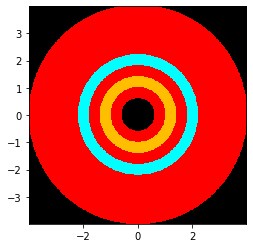

In [4]:
#plt.figure()
#imshow_field(make_ring_mask(0.15,0.3,0.4,pupil_grid))
#plt.figure()
#imshow_field(make_ring_phase_mask(0.15,0.3,0.4,np.pi/4,pupil_grid))

imshow_field(make_2ring_phase_mask(0.15,0.25,0.35,0.45,.55,np.pi/4,np.pi,pupil_grid))

# Test that one can produce a PSF right

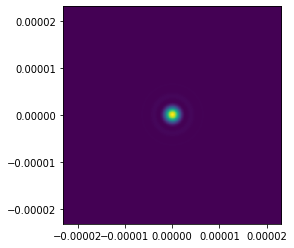

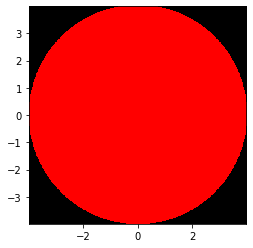

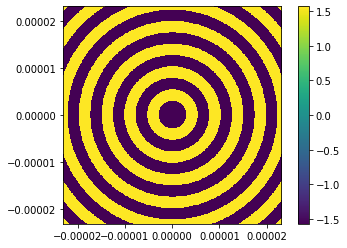

In [5]:
ap1 = make_obstructed_circular_aperture(8,0)
ap2 = make_ring_phase_mask(0,0.4,0.7,0*np.pi/2,pupil_grid)
telescope_pupil = ap2 #ap1(pupil_grid)

wf = Wavefront(telescope_pupil,wavelength)# * np.exp(1j * tilt * 2 * np.pi * pupil_grid.x), wavelength)
wf.total_power = 1
wf_foc = propagator(wf)
plt.figure()
imshow_field(wf_foc.intensity)
plt.figure()
plt.plot(focal_grid.x[0:512],wf_foc.intensity.shaped[256,:])
plt.axvline(-1.22*0.62 * um/D_pupil*focal_length)
plt.axvline(1.22*0.62 * um/D_pupil*focal_length)
plt.figure()
imshow_field(telescope_pupil)

plt.figure()
imshow_field(np.log10(wf_foc.intensity / wf_foc.intensity.max()), vmin=-5)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

plt.figure()
imshow_field(wf_foc.phase)
plt.colorbar()

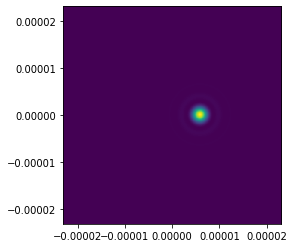

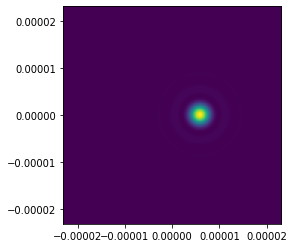

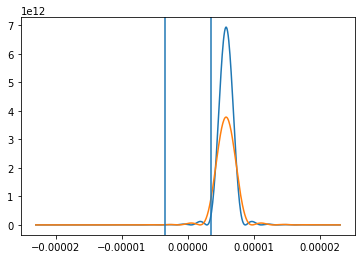

In [8]:
wf1 = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * np.pi * pupil_grid.x / D_pupil * .75/.620),wavelength)
wf2 = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * np.pi * pupil_grid.x / D_pupil*.75/.84),0.840*um)
wf_foc1 = propagator(wf1)
wf_foc2 = propagator(wf2)

plt.figure()
imshow_field(wf_foc1.intensity)
plt.figure()
imshow_field(wf_foc2.intensity)

plt.figure()
plt.plot(focal_grid.x[0:512],wf_foc1.intensity.shaped[256,:])
plt.plot(focal_grid.x[0:512],wf_foc2.intensity.shaped[256,:])
plt.axvline(-1.22*0.75 * um/D_pupil*focal_length)
plt.axvline(1.22*0.75 * um/D_pupil*focal_length)


plt.figure()
plt.semilogy(focal_grid.x[0:512],wf_foc1.intensity.shaped[256,:])
plt.semilogy(focal_grid.x[0:512],wf_foc2.intensity.shaped[256,:])
plt.axvline(-1.22*0.75 * um/D_pupil*focal_length)
plt.axvline(1.22*0.75 * um/D_pupil*focal_length)

plt.axvline(2*0.75 * um/D_pupil*focal_length,color = "r")
plt.axvline(-2*0.75 * um/D_pupil*focal_length,color = "r")


# Optimization of the coupling into the fiber

Text(0.5, 1.0, 'max transmission radius : 1.81 $\\mu$m')

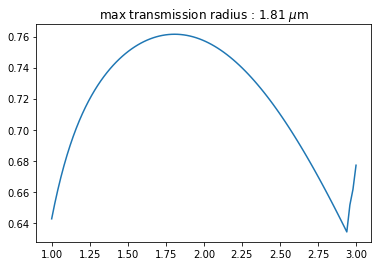

In [9]:
ap2 = make_ring_phase_mask(0.0,0.4,0.7,0*np.pi/2,pupil_grid)
telescope_pupil = ap2 #ap1(pupil_grid)

radiuses = np.linspace(1,3,100)
smf_coupling = []

for r in tqdm(radiuses):
    singlemode_fiber_core_radius = r * um
    single_mode_fiber = StepIndexFiber(singlemode_fiber_core_radius, fiber_NA, fiber_length)

    wf = Wavefront(telescope_pupil,wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling.append(wf_smf.total_power)
    
#plt.figure(1)
#plt.semilogy(r, smf_coupling)
#plt.figure(2)
plt.plot(radiuses, smf_coupling)
plt.title(f"max transmission radius : {radiuses[np.argmax(smf_coupling)]:0.3} $\mu$m")

Text(0.5, 1.0, 'max transmission radius : 1.79 $\\mu$m')

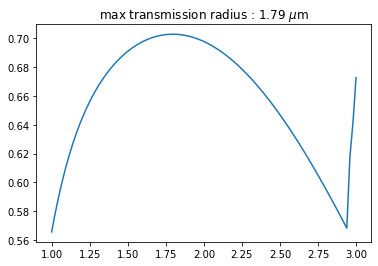

In [10]:
ap2 = make_ring_phase_mask(0.15,0.4,0.7,0*np.pi/2,pupil_grid)
telescope_pupil = ap2 #ap1(pupil_grid)

radiuses = np.linspace(1,3,100)
smf_coupling = []

for r in tqdm(radiuses):
    singlemode_fiber_core_radius = r * um
    single_mode_fiber = StepIndexFiber(singlemode_fiber_core_radius, fiber_NA, fiber_length)

    wf = Wavefront(telescope_pupil,wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling.append(wf_smf.total_power)
    
#plt.figure(1)
#plt.semilogy(r, smf_coupling)
#plt.figure(2)
plt.plot(radiuses, smf_coupling)
plt.title(f"max transmission radius : {radiuses[np.argmax(smf_coupling)]:0.3} $\mu$m")

In [11]:
singlemode_fiber_core_radius = 1.79 * um
single_mode_fiber = StepIndexFiber(singlemode_fiber_core_radius, fiber_NA, fiber_length)


# Test the fiber coupling with a "VLT" pupil

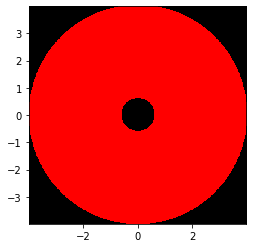

In [12]:
tilts = np.linspace(0, 5, 100)

telescope_pupil = make_ring_phase_mask(0.15,0.35,0.6,np.pi/2*0,pupil_grid)
plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []

for tilt in tqdm(tilts):
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 * np.pi * pupil_grid.x / D_pupil),wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling.append(wf_smf.total_power)

plt.figure()
plt.semilogy(tilts, smf_coupling)
plt.figure()
plt.plot(tilts, smf_coupling)

# Some random trials with a binary mask

## By hand


Mask transmission : 60.863343668018125


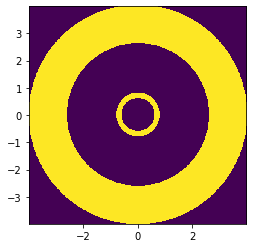

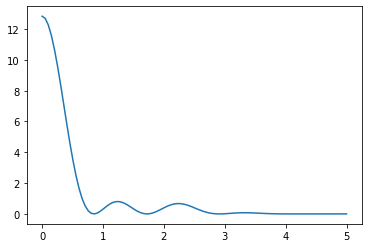

In [425]:
tilts = np.linspace(0, 5, 100)

telescope_pupil = make_ring_mask(0.15,0.2,0.65,pupil_grid)
full_pupil = make_ring_phase_mask(0.15,0.2,0.65,0,pupil_grid)
plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []


for tilt in tqdm(tilts):
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt *0.75/.620* 2 * np.pi * pupil_grid.x / D_pupil),wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling.append(wf_smf.total_power)

    
    
mask_tr = sum(telescope_pupil.real)/sum(full_pupil.real)
print(f"Mask transmission : {mask_tr*100}")
plt.figure()
plt.semilogy(tilts, np.array(smf_coupling)/max(smf_coupling))
plt.figure()
plt.plot(tilts, np.array(smf_coupling)*mask_tr*100)


## Try to optimize

In [464]:
def cost(x,l1 = .640, l2 =.750,l3=0.82):
    telescope_pupil = make_ring_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),pupil_grid)
    
    wf = Wavefront(telescope_pupil,wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    cmax =wf_smf.total_power

    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/l1 * np.pi * pupil_grid.x / D_pupil),l1 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    c2 = wf_smf.total_power
    
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/l2 * np.pi * pupil_grid.x / D_pupil),l2 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    c3 = wf_smf.total_power
    
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/l3 * np.pi * pupil_grid.x / D_pupil),l3 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    c4 = wf_smf.total_power

    return float( c2/cmax+c3/cmax+c4/cmax)

Let try at 2 wavelength to maximize the contrast. No care has been taken of the transmission

In [444]:
cost([0.2,0.45])

0.016043578591765213

In [466]:
x=fmin(cost,x0=[0.2,0.45])

Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 49
         Function evaluations: 96


In [459]:
x

array([ 0.59195437, -0.11726001])

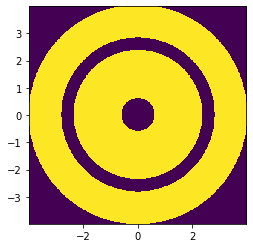

In [467]:
tilts = np.linspace(0, 3, 150)

telescope_pupil = make_ring_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),pupil_grid)
plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []

for tilt in tqdm(tilts):
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 * .75/.62 * np.pi * pupil_grid.x / D_pupil),wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    
    smf_coupling.append(wf_smf.total_power)
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 * np.pi * pupil_grid.x / D_pupil),0.750*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling2.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 *.75/.84 * np.pi * pupil_grid.x / D_pupil),0.840*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling1.append(wf_smf.total_power)

mask_tr = sum(telescope_pupil.real)/sum(full_pupil.real)

Mask transmission : 85.13395341442086 %


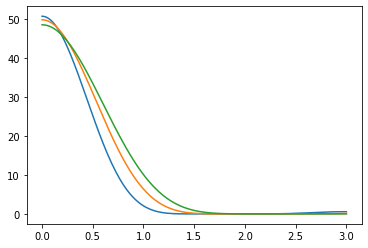

In [468]:
plt.figure()
plt.semilogy(tilts, np.array(smf_coupling)/max(smf_coupling),label="620 nm")
plt.semilogy(tilts, np.array(smf_coupling2)/max(smf_coupling2),label = "750 nm")
plt.semilogy(tilts, np.array(smf_coupling1)/max(smf_coupling1),label = "840 nm")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.axvline(2,color = "r", linestyle ="--")
plt.legend()

plt.figure()
plt.plot(tilts, np.array(smf_coupling)*mask_tr*100)
plt.plot(tilts, np.array(smf_coupling2)*mask_tr*100)
plt.plot(tilts, np.array(smf_coupling1)*mask_tr*100)

print(f"Mask transmission : {mask_tr*100} %")

Transmission is actually not that bad and the results seem pretty nice

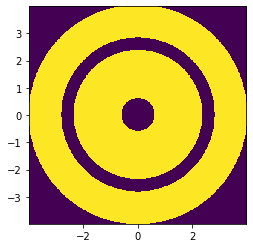

In [469]:
lll = np.linspace(.620, .840, 100)

plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []
smf_coupling3 = []

for l in tqdm(lll):
    telescope_pupil = make_ring_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),pupil_grid)
    telescope_pupil3 = make_ring_phase_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),0 ,pupil_grid)

    #binary mask
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling.append(wf_smf.total_power)
    
    #no mask
    wf = Wavefront(telescope_pupil3*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling3.append(wf_smf.total_power)
    
    #transmission on axis
    wf = Wavefront(telescope_pupil,l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling1.append(wf_smf.total_power)



Text(0, 0.5, 'transmission in %')

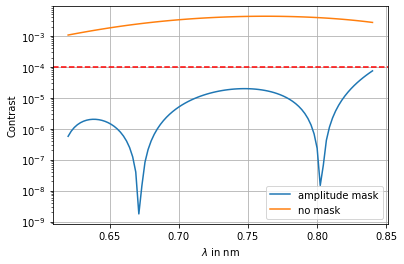

In [470]:
plt.figure()
plt.semilogy(lll, np.array(smf_coupling)/np.array(smf_coupling1),label="amplitude mask")
plt.semilogy(lll, np.array(smf_coupling3)/np.array(smf_coupling1),label="no mask")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.legend()
plt.grid()
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Contrast")


plt.figure()
plt.plot(lll, np.array(smf_coupling1)*mask_tr*100)
plt.xlabel("$\lambda$ in nm")
plt.ylabel("transmission in %")

**Too good to be True ?** 

In [471]:
telescope_pupil = make_ring_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),pupil_grid)
wf = Wavefront(telescope_pupil,0.75*um)
wf.total_power = 1
wf_foc = propagator(wf)
plt.figure()
imshow_field(np.log10(wf_foc.intensity / wf_foc.intensity.max()), vmin=-5)

plt.figure()
plt.semilogy(focal_grid.x[0:512],wf_foc.intensity.shaped[256,:])

plt.axvline(-1.22*0.75 * um/D_pupil*focal_length,color = "k")
plt.axvline(1.22*0.75 * um/D_pupil*focal_length,color = "k")

plt.axvline(2*0.75 * um/D_pupil*focal_length,color = "r")
plt.axvline(-2*0.75 * um/D_pupil*focal_length,color = "r")

# Some trial with a phase mask

## By hand

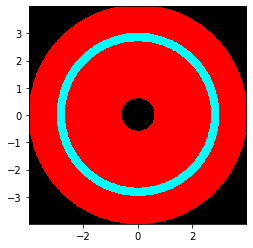

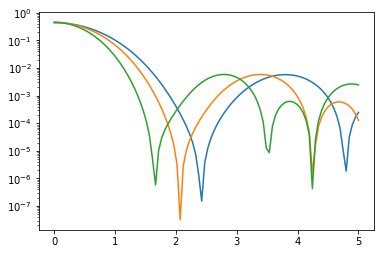

In [23]:
tilts = np.linspace(0, 5, 100)

telescope_pupil = make_ring_phase_mask(0.15,0.15+0.5170,0.15+0.5937 , -np.pi,pupil_grid)
telescope_pupil1 = make_ring_phase_mask(0.15,0.15+0.5170,0.15+0.5937 , -3.134602223058111,pupil_grid)
plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling0 = []

for tilt in tqdm(tilts):
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt *.75/.62* 2 * np.pi * pupil_grid.x / D_pupil),wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling0.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil1*np.exp(1j * tilt * 2 * np.pi * pupil_grid.x / D_pupil),0.750*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling1.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil1*np.exp(1j * tilt * .75/.84 * 2 * np.pi * pupil_grid.x / D_pupil),0.840*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling.append(wf_smf.total_power)

plt.figure()
plt.semilogy(tilts, smf_coupling)
plt.semilogy(tilts, smf_coupling1)
plt.semilogy(tilts, smf_coupling0)

plt.figure()
plt.plot(tilts, smf_coupling)
plt.plot(tilts, smf_coupling1)
plt.plot(tilts, smf_coupling0)

## Optimization on the contrast only at 2 wavelength (achromatic phase)

In [24]:
def cost(x):
    telescope_pupil = make_ring_phase_mask(0.15,abs(x[0])+0.15,abs(x[1])+0.15,x[2],pupil_grid)
    
    wf = Wavefront(telescope_pupil,wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    cmax =wf_smf.total_power
    
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/.693 * np.pi * pupil_grid.x / D_pupil),0.693 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    c2 = wf_smf.total_power
    
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/0.766 * np.pi * pupil_grid.x / D_pupil),0.766 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    c3 = wf_smf.total_power
    
    #wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * np.pi * pupil_grid.x / D_pupil),wavelength)
    #wf.total_power = 1
    #wf_foc = propagator(wf)
    #wf_smf = single_mode_fiber.forward(wf_foc)
    #c2 = wf_smf.total_power

    return float(c2/cmax+c3/cmax)



In [25]:
cost([0.5,0.6,-np.pi])

0.0015412324409960366

In [26]:
x=fmin(cost,x0=[0.5,0.6,-np.pi])
x

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 51
         Function evaluations: 102


array([ 0.47536451,  0.53599315, -3.14199515])

In [27]:
np.pi

3.141592653589793

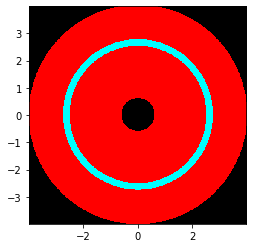

In [28]:
tilts = np.linspace(0, 5, 100)

telescope_pupil = make_ring_phase_mask(0.15,0.15+0.47536451,0.15+0.53599315 , -3.14199515,pupil_grid)
telescope_pupil1 = make_ring_phase_mask(0.15,0.15+0.47536451,0.15+0.53599315 , -3.14199515,pupil_grid)
plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling0 = []

for tilt in tqdm(tilts):
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt *.75/.62* 2 * np.pi * pupil_grid.x / D_pupil),wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling0.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil1*np.exp(1j * tilt * 2 * np.pi * pupil_grid.x / D_pupil),0.750*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling1.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil1*np.exp(1j * tilt * .75/.84 * 2 * np.pi * pupil_grid.x / D_pupil),0.840*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling.append(wf_smf.total_power)



In [29]:
plt.figure()
plt.semilogy(tilts, smf_coupling)
plt.semilogy(tilts, smf_coupling1)
plt.semilogy(tilts, smf_coupling0)
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.axvline(2,color = "r", linestyle ="--")
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Flux coupled in the Fiber")

plt.figure()
plt.plot(tilts, smf_coupling)
plt.plot(tilts, smf_coupling1)
plt.plot(tilts, smf_coupling0)
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Flux coupled in the fiber")


Text(0, 0.5, 'Flux coupled in the fiber')

In [6]:
def caf2(x):
    n=(1+0.437387571/(1-0.00173799328/x**2)+0.449211397/(1-0.00782718648/x**2)+0.152068715/(1-0.0124086125/x**2)+13.0020420/(1-4039.76541/x**2))**.5
    return n

In [7]:
e = .766 /(caf2(.766)-1)/ 2  

In [32]:
e

0.8888644799261098

In [33]:
2*np.pi/0.766*(caf2(0.75)-1)*e

3.142980446394179

In [34]:
2*np.pi/0.766*(caf2(0.840)-1)*e

3.1359869278526054

In [35]:
lll = np.linspace(.620, .840, 100)

plt.figure()
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []
smf_coupling3 = []

for l in tqdm(lll):
    telescope_pupil = make_ring_phase_mask(0.15,0.15+0.47536451,0.15+0.53599315 ,-np.pi ,pupil_grid) #-2*np.pi/l*(caf2(l)-1)*e
    telescope_pupil1 = make_ring_phase_mask(0.15,0.15+0.47536451,0.15+0.53599315 ,-2*np.pi/l*(caf2(l)-1)*e ,pupil_grid)
    telescope_pupil3 = make_ring_phase_mask(0.15,0.15+0.5170+0.0,0.15+0.53599315 ,0 ,pupil_grid)
    
    # achromatic mask
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling.append(wf_smf.total_power)
    
    # simple CAF2 mask
    wf = Wavefront(telescope_pupil1*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling2.append(wf_smf.total_power)
    
    #no mask
    wf = Wavefront(telescope_pupil3*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling3.append(wf_smf.total_power)

    #transmission on axis
    wf = Wavefront(telescope_pupil,l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling1.append(wf_smf.total_power)

    





<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'transmission in %')

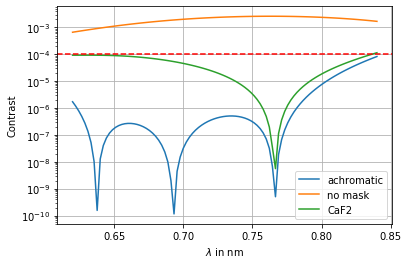

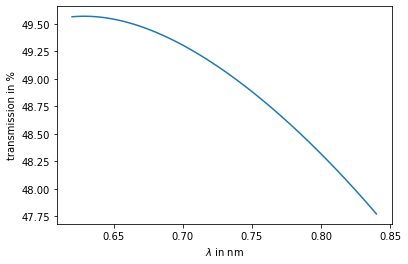

In [36]:
plt.figure()
plt.semilogy(lll, smf_coupling,label = "achromatic")
plt.semilogy(lll, smf_coupling3,label = "no mask")
plt.semilogy(lll, smf_coupling2,label = "CaF2")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.legend()
plt.grid()
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Contrast")

plt.figure()
plt.plot(lll, np.array(smf_coupling1)*100)
plt.xlabel("$\lambda$ in nm")
plt.ylabel("transmission in %")


**Not awful but less good than binary mask ?** 
**Can the techno of vector phase apodiser do better ?**

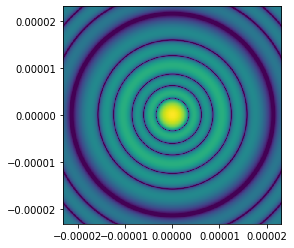

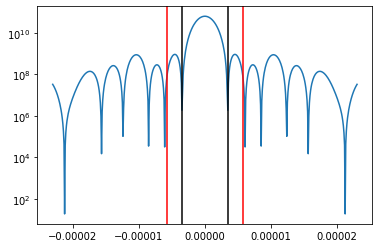

In [37]:
telescope_pupil = make_ring_phase_mask(0.15,0.15+0.47536451,0.15+0.53599315 ,-np.pi ,pupil_grid)
wf = Wavefront(telescope_pupil,0.75*um)
wf.total_power = 1
wf_foc = propagator(wf)
plt.figure()
imshow_field(np.log10(wf_foc.intensity / wf_foc.intensity.max()), vmin=-5)

plt.figure()
plt.semilogy(focal_grid.x[0:512],wf_foc.intensity.shaped[256,:])

plt.axvline(-1.22*0.75 * um/D_pupil*focal_length,color = "k")
plt.axvline(1.22*0.75 * um/D_pupil*focal_length,color = "k")

plt.axvline(2*0.75 * um/D_pupil*focal_length,color = "r")
plt.axvline(-2*0.75 * um/D_pupil*focal_length,color = "r")

## Optimization at two wavelength using CAF2 chromaticity

In [38]:
def cost(x):
    telescope_pupil = make_ring_phase_mask(0.15,abs(x[0])+0.15,abs(x[1])+0.15,-2*np.pi/0.62*(caf2(0.62)-1)*x[2],pupil_grid)
    telescope_pupil1 = make_ring_phase_mask(0.15,abs(x[0])+0.15,abs(x[1])+0.15,-2*np.pi/0.693*(caf2(0.65)-1)*x[2],pupil_grid)
    telescope_pupil2 = make_ring_phase_mask(0.15,abs(x[0])+0.15,abs(x[1])+0.15,-2*np.pi/0.766*(caf2(0.8)-1)*x[2],pupil_grid)
    
    
    
    wf = Wavefront(telescope_pupil,wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    cmax =wf_smf.total_power
    
    wf = Wavefront(telescope_pupil1*np.exp(1j * 2 * 2 * 0.75/.650 * np.pi * pupil_grid.x / D_pupil),0.65 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    c2 = wf_smf.total_power
    
    wf = Wavefront(telescope_pupil2*np.exp(1j * 2 * 2 * 0.75/0.800 * np.pi * pupil_grid.x / D_pupil),0.8 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    c3 = wf_smf.total_power
    
    #wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * np.pi * pupil_grid.x / D_pupil),wavelength)
    #wf.total_power = 1
    #wf_foc = propagator(wf)
    #wf_smf = single_mode_fiber.forward(wf_foc)
    #c2 = wf_smf.total_power

    return float(c2/cmax+c3/cmax)


In [39]:
cost([0.5,0.6,e])

0.002094321040550409

In [40]:
x=fmin(cost,x0=[0.5,0.6,e])
x

Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 62
         Function evaluations: 116


array([0.47143916, 0.52843699, 0.85782086])

In [41]:
lll = np.linspace(.620, .840, 100)


ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []
smf_coupling3 = []

for l in tqdm(lll):
    telescope_pupil = make_ring_phase_mask(0.15,0.15+0.47536451,0.15+0.53599315 ,-np.pi ,pupil_grid) #-2*np.pi/l*(caf2(l)-1)*e
    telescope_pupil1 = make_ring_phase_mask(0.15,0.15+0.47143916,0.15+0.52843699 ,-2*np.pi/l*(caf2(l)-1)*0.85782086 ,pupil_grid)
    telescope_pupil3 = make_ring_phase_mask(0.15,0.15+0.5170+0.0,0.15+0.53599315 ,0 ,pupil_grid)
    
    # achromatic mask
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling.append(wf_smf.total_power)
    
    # simple CAF2 mask
    wf = Wavefront(telescope_pupil1*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling2.append(wf_smf.total_power)
    
    #no mask
    wf = Wavefront(telescope_pupil3*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling3.append(wf_smf.total_power)

    #transmission on axis
    wf = Wavefront(telescope_pupil,l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling1.append(wf_smf.total_power)

Text(0, 0.5, 'transmission in %')

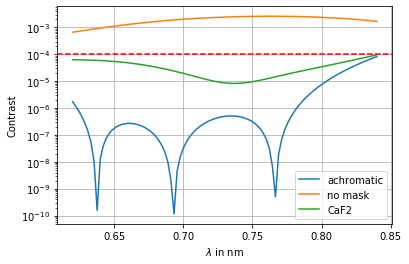

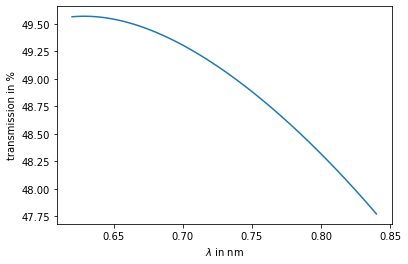

In [42]:
plt.figure()
plt.semilogy(lll, smf_coupling,label = "achromatic")
plt.semilogy(lll, smf_coupling3,label = "no mask")
plt.semilogy(lll, smf_coupling2,label = "CaF2")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.legend()
plt.grid()
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Contrast")

plt.figure()
plt.plot(lll, np.array(smf_coupling1)*100)
plt.xlabel("$\lambda$ in nm")
plt.ylabel("transmission in %")

**No improvement if the optimization takes into account the chromaticity**

In [8]:
lll = np.linspace(.620, .840, 100)


ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []
smf_coupling3 = []

for l in tqdm(lll):
    telescope_pupil = make_ring_phase_mask(0.15,0.15+0.47536451,0.15+0.53599315 ,np.pi ,pupil_grid) #-2*np.pi/l*(caf2(l)-1)*e
    telescope_pupil1 = make_ring_phase_mask(0.15,0.15+0.47143916,0.15+0.52843699 ,2*np.pi/l*(caf2(l)-1)*0.85782086 ,pupil_grid)
    telescope_pupil3 = make_ring_phase_mask(0.15,0.15+0.5170+0.0,0.15+0.53599315 ,0 ,pupil_grid)
    
    # achromatic mask
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling.append(wf_smf.total_power)
    
    # simple CAF2 mask
    wf = Wavefront(telescope_pupil1*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling2.append(wf_smf.total_power)
    
    #no mask
    wf = Wavefront(telescope_pupil3*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling3.append(wf_smf.total_power)

    #transmission on axis
    wf = Wavefront(telescope_pupil,l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling1.append(wf_smf.total_power)

In [9]:
plt.figure()
plt.semilogy(lll, smf_coupling,label = "achromatic")
plt.semilogy(lll, smf_coupling3,label = "no mask")
plt.semilogy(lll, smf_coupling2,label = "CaF2")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.legend()
plt.grid()
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Contrast")

plt.figure()
plt.plot(lll, np.array(smf_coupling1)*100)
plt.xlabel("$\lambda$ in nm")
plt.ylabel("transmission in %")

Text(0, 0.5, 'transmission in %')

# Now with a lenslet : Phase Mask

## Optimization

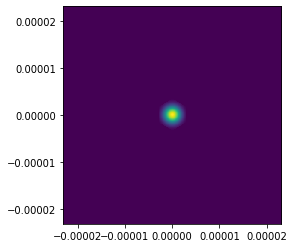

In [195]:
lenslet = hexagonal_aperture(4/np.sqrt(3)*0.75 * um/D_pupil*focal_length)
lenslet1 = circular_aperture(4/np.sqrt(3)*0.75 * um/D_pupil*focal_length)
ap = lenslet(focal_grid)
ap2 = lenslet1(focal_grid)
plt.figure(1)
imshow_field(ap*wf_foc.intensity)

apo = Apodizer(ap)
propagator2 = FraunhoferPropagator(focal_grid,focal_grid,focal_length = 4/np.sqrt(3)*0.75 * um/D_pupil*focal_length*1/.12/2)

plt.figure(2)
wf_foc2 = propagator2(apo(wf_foc))
imshow_field(np.log10(wf_foc2.intensity / wf_foc2.intensity.max()), vmin=-5)

In [142]:
singlemode_fiber_core_radius = 3.5/2 * um
single_mode_fiber = StepIndexFiber(singlemode_fiber_core_radius, fiber_NA, fiber_length)

In [290]:
ap2 = make_ring_phase_mask(0.15,0.4,0.7,0*np.pi/2,pupil_grid)
telescope_pupil = ap2 #ap1(pupil_grid)

ffl = np.linspace(0.5,10,100)
smf_coupling = []

for r in tqdm(ffl):
    
    propagator2 = FraunhoferPropagator(focal_grid,focal_grid,focal_length = r/np.sqrt(3)*0.75 * um/D_pupil*focal_length*1/.12/2)
    wf = Wavefront(telescope_pupil,0.750*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling.append(wf_smf.total_power)
    
#plt.figure(1)
#plt.semilogy(r, smf_coupling)
#plt.figure(2)
plt.plot(ffl, smf_coupling)
plt.title(f"max transmission r : {ffl[np.argmax(smf_coupling)]:0.3}" )

Text(0.5, 1.0, 'max transmission r : 2.9')

In [319]:
#propagator2 = FraunhoferPropagator(focal_grid,focal_grid,focal_length = 2.52/np.sqrt(3)*0.75 * um/D_pupil*focal_length*1/.12/2)
propagator2 = FraunhoferPropagator(focal_grid,focal_grid,focal_length = 2.9/np.sqrt(3)*0.75 * um/D_pupil*focal_length*1/.12/2)

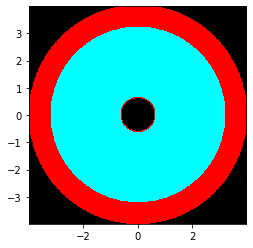

In [249]:
tilts = np.linspace(0, 5, 100)

telescope_pupil = make_ring_phase_mask(0.15,0.16,0.8 , -3.14199515,pupil_grid)
telescope_pupil1 = make_ring_phase_mask(0.15,0.16,0.8 , -3.14199515,pupil_grid)
plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling0 = []

for tilt in tqdm(tilts):
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt *.75/.62* 2 * np.pi * pupil_grid.x / D_pupil),wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling0.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil1*np.exp(1j * tilt * 2 * np.pi * pupil_grid.x / D_pupil),0.750*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling1.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil1*np.exp(1j * tilt * .75/.84 * 2 * np.pi * pupil_grid.x / D_pupil),0.840*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling.append(wf_smf.total_power)


Text(0, 0.5, 'Flux coupled in the fiber')

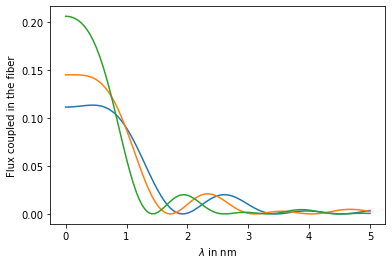

In [250]:
plt.figure()
plt.semilogy(tilts, smf_coupling)
plt.semilogy(tilts, smf_coupling1)
plt.semilogy(tilts, smf_coupling0)
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.axvline(2,color = "r", linestyle ="--")
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Flux coupled in the Fiber")

plt.figure()
plt.plot(tilts, smf_coupling)
plt.plot(tilts, smf_coupling1)
plt.plot(tilts, smf_coupling0)
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Flux coupled in the fiber")


In [308]:
def cost(x):
    telescope_pupil = make_ring_phase_mask(0.15,abs(x[0])+0.15,abs(x[0])+abs(x[1])+0.15,x[2],pupil_grid)
    
    wf = Wavefront(telescope_pupil,wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    tmax= sum(apo(wf_foc).intensity)/sum(wf_foc.intensity)
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    cmax =wf_smf.total_power
    
    #wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/.675 * np.pi * pupil_grid.x / D_pupil),0.675 * um)
    #wf.total_power = 1
    #wf_foc = propagator(wf)
    #wf_foc2 = propagator2(apo(wf_foc))
    #wf_smf = single_mode_fiber.forward(wf_foc2)
    #c2 = wf_smf.total_power
    
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/0.690 * np.pi * pupil_grid.x / D_pupil),0.690 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    t3= sum(apo(wf_foc).intensity)/sum(wf_foc.intensity)
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    c3 = wf_smf.total_power
    
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/0.770 * np.pi * pupil_grid.x / D_pupil),0.770 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    t4= sum(apo(wf_foc).intensity)/sum(wf_foc.intensity)
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    c4 = wf_smf.total_power
    
    #wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * np.pi * pupil_grid.x / D_pupil),wavelength)
    #wf.total_power = 1
    #wf_foc = propagator(wf)
    #wf_smf = single_mode_fiber.forward(wf_foc)
    #c2 = wf_smf.total_power

    return float((t3*c3)/(cmax*tmax)+(c4*t4)/(cmax*tmax)+(1-cmax*tmax)*3e-4)


In [300]:
cost([0.5,0.1,-np.pi])

8.199046401752626e-05

In [309]:
x=fmin(cost,x0=[0.5,0.1,-np.pi])
x

Optimization terminated successfully.
         Current function value: 0.000220
         Iterations: 104
         Function evaluations: 201


array([ 0.48695959,  0.06784154, -3.14156022])

In [310]:
tilts = np.linspace(0, 5, 100)

telescope_pupil = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]) , x[2],pupil_grid)
telescope_pupil1 = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]) , x[2],pupil_grid)
plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling0 = []

t = []
t1 = []
t0 = []

# smf_coupling_1 = []
# smf_coupling1_1 = []
# smf_coupling0_1 = []

for tilt in tqdm(tilts):
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt *.75/.62* 2 * np.pi * pupil_grid.x / D_pupil),wavelength)
    wf.total_power = 1
    wf_foc_0 = propagator(wf)
    wf_foc2_0 = propagator2(apo(wf_foc_0))
    t0.append(sum(apo(wf_foc_0).intensity)/sum(wf_foc_0.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2_0)
    smf_coupling0.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil1*np.exp(1j * tilt * 2 * np.pi * pupil_grid.x / D_pupil),0.750*um)
    wf.total_power = 1
    wf_foc_1 = propagator(wf)
    t1.append(sum(apo(wf_foc_1).intensity)/sum(wf_foc_1.intensity))
    wf_foc2_1 = propagator2(apo(wf_foc_1))
    wf_smf = single_mode_fiber.forward(wf_foc2_1)
    smf_coupling1.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil1*np.exp(1j * tilt * .75/.84 * 2 * np.pi * pupil_grid.x / D_pupil),0.840*um)
    wf.total_power = 1
    wf_foc_2 = propagator(wf)
    t.append(sum(apo(wf_foc_2).intensity)/sum(wf_foc_2.intensity))
    wf_foc2_2 = propagator2(apo(wf_foc_2))
    wf_smf = single_mode_fiber.forward(wf_foc2_2)
    smf_coupling.append(wf_smf.total_power)
    
#     wf = Wavefront(telescope_pupil*np.exp(1j * tilt *.75/.62* 2 * np.pi * (1/np.sqrt(2)*(pupil_grid.y+pupil_grid.x)) / D_pupil),wavelength)
#     wf.total_power = 1
#     wf_foc_0 = propagator(wf)
#     wf_foc2_0 = propagator2(apo(wf_foc_0))
#     wf_smf = single_mode_fiber.forward(wf_foc2_0)
#     smf_coupling0_1.append(wf_smf.total_power)
    
#     wf = Wavefront(telescope_pupil1*np.exp(1j * tilt * 2 * np.pi * (1/np.sqrt(2)*(pupil_grid.y+pupil_grid.x)) / D_pupil),0.750*um)
#     wf.total_power = 1
#     wf_foc_1 = propagator(wf)
#     wf_foc2_1 = propagator2(apo(wf_foc_1))
#     wf_smf = single_mode_fiber.forward(wf_foc2_1)
#     smf_coupling1_1.append(wf_smf.total_power)
    
#     wf = Wavefront(telescope_pupil1*np.exp(1j * tilt * .75/.84 * 2 * np.pi * (1/np.sqrt(2)*(pupil_grid.y+pupil_grid.x)) / D_pupil),0.840*um)
#     wf.total_power = 1
#     wf_foc_2 = propagator(wf)
#     wf_foc2_2 = propagator2(apo(wf_foc_2))
#     wf_smf = single_mode_fiber.forward(wf_foc2_2)
#     smf_coupling_1.append(wf_smf.total_power)


Text(0, 0.5, 'Flux coupled in the fiber')

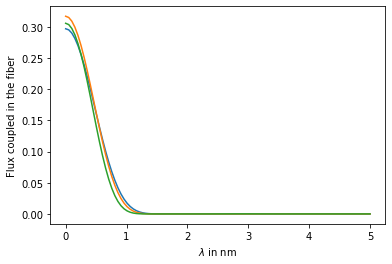

In [311]:
plt.figure()
plt.semilogy(tilts, (np.array(smf_coupling)*np.array(t))/(max(smf_coupling)*max(t)),"C0",label = "840 nm")
plt.semilogy(tilts, (np.array(smf_coupling1)*np.array(t1))/(max(smf_coupling1)*max(t1)),"C1",label = "750 nm")
plt.semilogy(tilts, (np.array(smf_coupling0)*np.array(t0))/(max(smf_coupling0)*max(t0)),"C2",label = "620 nm")

# plt.semilogy(tilts, np.array(smf_coupling_1)/max(smf_coupling_1),"C0--",label = "840 nm")
# plt.semilogy(tilts, np.array(smf_coupling1_1)/max(smf_coupling1_1),"C1--",label = "750 nm")
# plt.semilogy(tilts, np.array(smf_coupling0_1)/max(smf_coupling0_1),"C2--",label = "620 nm")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.axvline(2,color = "r", linestyle ="--")
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Contrast in the Fiber")
plt.legend()


plt.figure()
plt.plot(tilts, np.array(smf_coupling)*np.array(t))
plt.plot(tilts, np.array(smf_coupling1)*np.array(t1))
plt.plot(tilts, np.array(smf_coupling0)*np.array(t0))
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Flux coupled in the fiber")


In [320]:
lll = np.linspace(.620, .840, 100)

plt.figure()
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []
smf_coupling3 = []
smf_coupling4 = []

t = []
t1 = []
t2 = []
t3 = []
t4 = []

for l in tqdm(lll):
    telescope_pupil = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]), x[2] ,pupil_grid) #-2*np.pi/l*(caf2(l)-1)*e
    telescope_pupil1 = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]),-2*np.pi/l*(caf2(l)-1)*e ,pupil_grid)
    telescope_pupil3 = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]) ,0 ,pupil_grid)
    
    # achromatic mask
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc1 = propagator(wf)
    t.append(sum(apo(wf_foc1).intensity)/sum(wf_foc1.intensity))
    wf_foc2 = propagator2(apo(wf_foc1))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling.append(wf_smf.total_power)
    
    
    # simple CAF2 mask
    wf = Wavefront(telescope_pupil1*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    t2.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling2.append(wf_smf.total_power)
    
    #no mask
    wf = Wavefront(telescope_pupil3*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t3.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling3.append(wf_smf.total_power)

    #transmission on axis
    wf = Wavefront(telescope_pupil,l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t1.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling1.append(wf_smf.total_power)
    
    #transmission on axis no mask
    wf = Wavefront(telescope_pupil3,l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t4.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    
    smf_coupling4.append(wf_smf.total_power)


<Figure size 432x288 with 0 Axes>

In [281]:
smf_coupling1

[]

Text(0, 0.5, 'transmission in %')

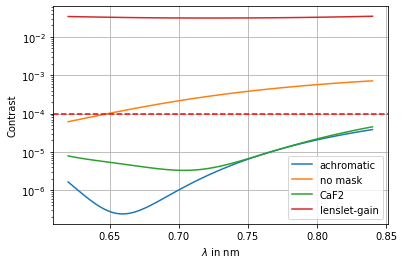

In [321]:
plt.figure()
plt.semilogy(lll, (np.array(smf_coupling)*np.array(t))/(np.array(smf_coupling1)*np.array(t1)),label = "achromatic")
plt.semilogy(lll, (np.array(smf_coupling3)*np.array(t3))/(np.array(smf_coupling1)*np.array(t1)),label = "no mask")
plt.semilogy(lll, (np.array(smf_coupling2)*np.array(t2))/(np.array(smf_coupling1)*np.array(t1)),label = "CaF2")
plt.semilogy(lll, np.array(t3)/np.array(t1),label = "lenslet-gain")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.legend()
plt.grid()
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Contrast")

plt.figure()
plt.plot(lll, np.array(t1)*np.array(smf_coupling1)*100)
plt.plot(lll, np.array(t4)*np.array(smf_coupling4)*100)
plt.xlabel("$\lambda$ in nm")
plt.ylabel("transmission in %")

In [240]:
plt.figure()
ax=plt.subplot(111)
imshow_field(np.log10(wf_foc.intensity / wf_foc.intensity.max()), vmin=-5)
h=RegularPolygon((0,0),6,radius = 2/np.sqrt(3)*0.75 * um/D_pupil*focal_length,fill = False, ec ="r")
h1=RegularPolygon((2*0.75 * um/D_pupil*focal_length,0),6,radius = 2/np.sqrt(3)*0.75 * um/D_pupil*focal_length,fill = False, ec ="r")
ax.add_artist(h)
ax.add_artist(h1)

plt.figure()
ax=plt.subplot(111)
wf_foc3 = propagator2(apo(wf_foc1))
imshow_field(np.log10(wf_foc3.intensity / wf_foc3.intensity.max()), vmin=-5)
h=Circle((0,0),radius = singlemode_fiber_core_radius,fill = False, ec ="r")
ax.add_artist(h)

plt.figure()
ax=plt.subplot(111)
wf_foc3 = propagator2(apo(wf_foc1))
imshow_field(wf_foc3.phase)
h=Circle((0,0),radius = singlemode_fiber_core_radius,fill = False, ec ="r")
h1=Circle((0,0),radius = 125/2*um,fill = False, ec ="r")
ax.add_artist(h)
ax.add_artist(h1)

In [172]:
np.linspace(0.5,0.5,1)

array([0.5])

* Calculate the max transmission with a lenslet
* Calculate the contribution of abberations zernike
* ETC

In [265]:
lll = np.linspace(.750, .750, 1)

plt.figure()
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []
smf_coupling3 = []
t = []
t1 = []
t2 = []
t3 = []

for l in tqdm(lll):
    telescope_pupil = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]), x[2] ,pupil_grid) #-2*np.pi/l*(caf2(l)-1)*e
    telescope_pupil1 = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]),-2*np.pi/l*(caf2(l)-1)*e ,pupil_grid)
    telescope_pupil3 = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]) ,0 ,pupil_grid)
    
    # achromatic mask
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc1 = propagator(wf)
    t.append(sum(apo(wf_foc1).intensity)/sum(wf_foc1.intensity))
    wf_foc2 = propagator2(apo(wf_foc1))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling.append(wf_smf.total_power)
    t
    
    # simple CAF2 mask
    wf = Wavefront(telescope_pupil1*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    t2.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling2.append(wf_smf.total_power)
    
    #no mask
    wf = Wavefront(telescope_pupil3*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t3.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling3.append(wf_smf.total_power)

    #transmission on axis
    wf = Wavefront(telescope_pupil,l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t1.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    
    smf_coupling1.append(wf_smf.total_power)


<Figure size 432x288 with 0 Axes>

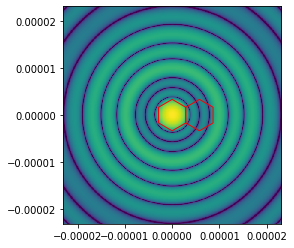

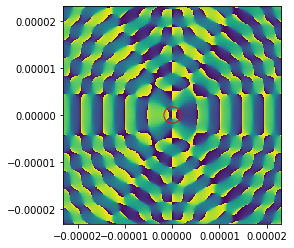

In [263]:
plt.figure()
ax=plt.subplot(111)
imshow_field(np.log10(wf_foc.intensity / wf_foc.intensity.max()), vmin=-5)
h=RegularPolygon((0,0),6,radius = 2/np.sqrt(3)*0.75 * um/D_pupil*focal_length,fill = False, ec ="r")
h1=RegularPolygon((2*0.75 * um/D_pupil*focal_length,0),6,radius = 2/np.sqrt(3)*0.75 * um/D_pupil*focal_length,fill = False, ec ="r")
ax.add_artist(h)
ax.add_artist(h1)

plt.figure()
ax=plt.subplot(111)
wf_foc3 = propagator2(apo(wf_foc1))
imshow_field(np.log10(wf_foc3.intensity / wf_foc3.intensity.max()), vmin=-5)
h=Circle((0,0),radius = singlemode_fiber_core_radius,fill = False, ec ="r")
ax.add_artist(h)

plt.figure()
ax=plt.subplot(111)
wf_foc3 = propagator2(apo(wf_foc1))
imshow_field(wf_foc3.phase)
h=Circle((0,0),radius = singlemode_fiber_core_radius,fill = False, ec ="r")
h1=Circle((0,0),radius = 125/2*um,fill = False, ec ="r")
ax.add_artist(h)
ax.add_artist(h1)

In [314]:
ap2 = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]), x[2],pupil_grid)
telescope_pupil = ap2 #ap1(pupil_grid)

ffl = np.linspace(0.5,10,100)
smf_coupling = []

for r in tqdm(ffl):
    
    propagator2 = FraunhoferPropagator(focal_grid,focal_grid,focal_length = r/np.sqrt(3)*0.75 * um/D_pupil*focal_length*1/.12/2)
    wf = Wavefront(telescope_pupil,0.750*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    
    smf_coupling.append(wf_smf.total_power)
    
#plt.figure(1)
#plt.semilogy(r, smf_coupling)
#plt.figure(2)
plt.plot(ffl, smf_coupling)
plt.title(f"max transmission r : {ffl[np.argmax(smf_coupling)]:0.3}" )

Text(0.5, 1.0, 'max transmission r : 2.9')

In [322]:
propagator2 = FraunhoferPropagator(focal_grid,focal_grid,focal_length = 2.9/np.sqrt(3)*0.75 * um/D_pupil*focal_length*1/.12/2)

## Effect of abberations 

In [410]:
lll = np.linspace(.620, .840, 100)

plt.figure()
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []
smf_coupling3 = []
smf_coupling4 = []

t = []
t1 = []
t2 = []
t3 = []
t4 = []
ab=SurfaceAberration(pupil_grid,100e-9,8)
for l in tqdm(lll):
    telescope_pupil = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]), x[2] ,pupil_grid) #-2*np.pi/l*(caf2(l)-1)*e
    telescope_pupil1 = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]),-2*np.pi/l*(caf2(l)-1)*e ,pupil_grid)
    telescope_pupil3 = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]) ,0 ,pupil_grid)
    
    # achromatic mask
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    
    wf_foc1 = propagator(ab(wf))
    t.append(sum(apo(wf_foc1).intensity)/sum(wf_foc1.intensity))
    wf_foc2 = propagator2(apo(wf_foc1))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling.append(wf_smf.total_power)
    
    
    # simple CAF2 mask
    wf = Wavefront(telescope_pupil1*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(ab(wf))
    t2.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling2.append(wf_smf.total_power)
    
    #no mask
    wf = Wavefront(telescope_pupil3*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(ab(wf))
    wf_foc2 = propagator2(apo(wf_foc))
    t3.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling3.append(wf_smf.total_power)

    #transmission on axis
    wf = Wavefront(telescope_pupil,l*um)
    wf.total_power = 1
    wf_foc = propagator(ab(wf))
    wf_foc2 = propagator2(apo(wf_foc))
    t1.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling1.append(wf_smf.total_power)
    
    #transmission on axis no mask
    wf = Wavefront(telescope_pupil3,l*um)
    wf.total_power = 1
    wf_foc = propagator(ab(wf))
    wf_foc2 = propagator2(apo(wf_foc))
    t4.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    
    smf_coupling4.append(wf_smf.total_power)


/home/chazelas/anaconda3/lib/python3.7/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


<Figure size 432x288 with 0 Axes>

In [411]:
plt.figure()
plt.semilogy(lll, (np.array(smf_coupling)*np.array(t))/(np.array(smf_coupling1)*np.array(t1)),label = "achromatic")
plt.semilogy(lll, (np.array(smf_coupling3)*np.array(t3))/(np.array(smf_coupling1)*np.array(t1)),label = "no mask")
plt.semilogy(lll, (np.array(smf_coupling2)*np.array(t2))/(np.array(smf_coupling1)*np.array(t1)),label = "CaF2")
plt.semilogy(lll, np.array(t3)/np.array(t1),label = "lenslet-gain")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.legend()
plt.grid()
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Contrast")

plt.figure()
plt.plot(lll, np.array(t1)*np.array(smf_coupling1)*100)
plt.plot(lll, np.array(t4)*np.array(smf_coupling4)*100)
plt.xlabel("$\lambda$ in nm")
plt.ylabel("transmission in %")

Text(0, 0.5, 'transmission in %')

In [412]:
plt.figure()
ax=plt.subplot(111)
imshow_field(np.log10(wf_foc.intensity / wf_foc.intensity.max()), vmin=-5)
h=RegularPolygon((0,0),6,radius = 2/np.sqrt(3)*0.75 * um/D_pupil*focal_length,fill = False, ec ="r")
h1=RegularPolygon((2*0.75 * um/D_pupil*focal_length,0),6,radius = 2/np.sqrt(3)*0.75 * um/D_pupil*focal_length,fill = False, ec ="r")
ax.add_artist(h)
ax.add_artist(h1)

plt.figure()
ax=plt.subplot(111)
wf_foc3 = propagator2(apo(wf_foc1))
imshow_field(np.log10(wf_foc3.intensity / wf_foc3.intensity.max()), vmin=-5)
h=Circle((0,0),radius = singlemode_fiber_core_radius,fill = False, ec ="r")
ax.add_artist(h)

plt.figure()
ax=plt.subplot(111)
wf_foc3 = propagator2(apo(wf_foc1))
imshow_field(wf_foc3.phase)
h=Circle((0,0),radius = singlemode_fiber_core_radius,fill = False, ec ="r")
h1=Circle((0,0),radius = 125/2*um,fill = False, ec ="r")
ax.add_artist(h)
ax.add_artist(h1)

Text(0.5, 1.0, '18.53330278610104')

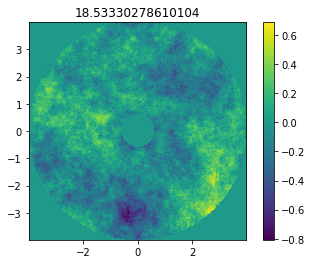

In [413]:
imshow_field(ab(wf).phase)
plt.colorbar()
plt.title(ab(wf).phase.std()/(2*np.pi)*750)

In [361]:
(m,n)=noll_to_zernike(5)
z = zernike(m,n,8)

Text(0.5, 1.0, '105.77226271227211')

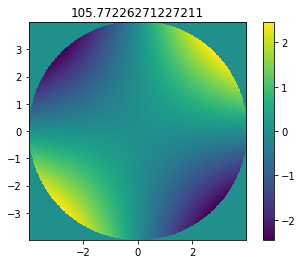

In [370]:
imshow_field(z(pupil_grid))
plt.colorbar()
plt.title(z(pupil_grid).std()/(2*np.pi)*750)

In [386]:
def make_one_zern_noll(i,pupil_grid,rms,l):
    (m,n)=noll_to_zernike(i)
    z = zernike(m,n,8)
    phase = z(pupil_grid)
    phase = phase/(phase.std()*l/2/np.pi)*rms
    return np.exp(1j*phase)

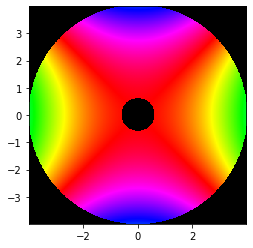

In [414]:
imshow_field(telescope_pupil3*make_one_zern_noll(6,pupil_grid,100,750))

In [416]:
lll = np.linspace(.620, .840, 2)

plt.figure()
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []
smf_coupling3 = []
smf_coupling4 = []

t = []
t1 = []
t2 = []
t3 = []
t4 = []
ab=SurfaceAberration(pupil_grid,0,8)
l = .750
zmodes = range(1,200)

for i in tqdm(zmodes):
    telescope_pupil = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]), x[2] ,pupil_grid)*make_one_zern_noll(i,pupil_grid,50,750) #-2*np.pi/l*(caf2(l)-1)*e
    telescope_pupil1 = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]),-2*np.pi/l*(caf2(l)-1)*e ,pupil_grid)*make_one_zern_noll(i,pupil_grid,50,750)
    telescope_pupil3 = make_ring_phase_mask(0.15,0.15+x[0],0.15+abs(x[0])+abs(x[1]) ,0 ,pupil_grid)*make_one_zern_noll(i,pupil_grid,50,750)
    
    # achromatic mask
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    
    wf_foc1 = propagator(wf)
    t.append(sum(apo(wf_foc1).intensity)/sum(wf_foc1.intensity))
    wf_foc2 = propagator2(apo(wf_foc1))
    #     plt.figure()
    #     imshow_field(wf_foc1.intensity)
    #     plt.figure()
    #     imshow_field(wf_foc2.intensity)
    
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling.append(wf_smf.total_power)
    
    
    # simple CAF2 mask
    wf = Wavefront(telescope_pupil1*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    t2.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_foc2 = propagator2(apo(wf_foc))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling2.append(wf_smf.total_power)
    
    #no mask
    wf = Wavefront(telescope_pupil3*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t3.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling3.append(wf_smf.total_power)

    #transmission on axis
    wf = Wavefront(telescope_pupil,l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t1.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling1.append(wf_smf.total_power)
    
    #transmission on axis no mask
    wf = Wavefront(telescope_pupil3,l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t4.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    
    smf_coupling4.append(wf_smf.total_power)


/home/chazelas/anaconda3/lib/python3.7/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Transmission in %')

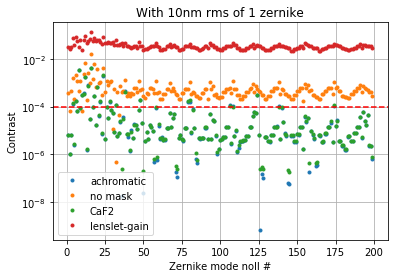

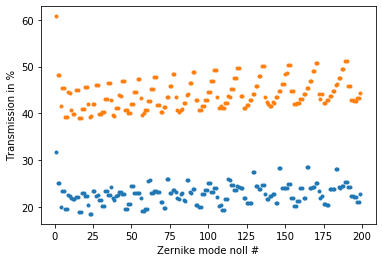

In [420]:
plt.figure()
plt.semilogy(zmodes, (np.array(smf_coupling)*np.array(t))/(np.array(smf_coupling1)*np.array(t1)),".",label = "achromatic")
plt.semilogy(zmodes, (np.array(smf_coupling3)*np.array(t3))/(np.array(smf_coupling1)*np.array(t1)),".",label = "no mask")
plt.semilogy(zmodes, (np.array(smf_coupling2)*np.array(t2))/(np.array(smf_coupling1)*np.array(t1)),".",label = "CaF2")
plt.semilogy(zmodes, np.array(t3)/np.array(t1),".",label = "lenslet-gain")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.legend()
plt.grid()
plt.xlabel("Zernike mode noll #")
plt.ylabel("Contrast")
plt.title("With 10nm rms of 1 zernike")

plt.figure()
plt.plot(zmodes, np.array(t1)*np.array(smf_coupling1)*100,".")
plt.plot(zmodes, np.array(t4)*np.array(smf_coupling4)*100,".")
plt.xlabel("Zernike mode noll #")
plt.ylabel("Transmission in %")

# With lenslet : binary mask

## Optimization

In [472]:
propagator2 = FraunhoferPropagator(focal_grid,focal_grid,focal_length = 2.9/np.sqrt(3)*0.75 * um/D_pupil*focal_length*1/.12/2)

In [473]:
singlemode_fiber_core_radius = 3.5/2 * um
single_mode_fiber = StepIndexFiber(singlemode_fiber_core_radius, fiber_NA, fiber_length)

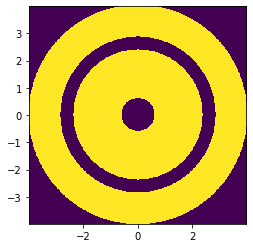

In [484]:
x=[0.59195437, 0.11726001]
tilts = np.linspace(0, 3, 150)

telescope_pupil = make_ring_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),pupil_grid)
plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []

tr=[]
tr1=[]
tr2=[]

for tilt in tqdm(tilts):
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 * .75/.62 * np.pi * pupil_grid.x / D_pupil),wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 * np.pi * pupil_grid.x / D_pupil),0.750*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr2.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling2.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 *.75/.84 * np.pi * pupil_grid.x / D_pupil),0.840*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr1.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling1.append(wf_smf.total_power)

mask_tr = sum(telescope_pupil.real)/sum(full_pupil.real)

Mask transmission : 84.3886636457588 %


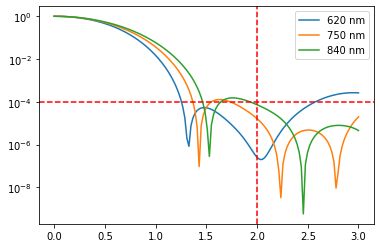

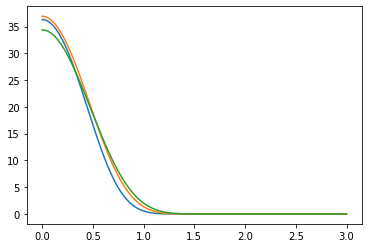

In [485]:
plt.figure()
plt.semilogy(tilts, (np.array(smf_coupling)*np.array(tr))/(max(smf_coupling)*max(tr)),label="620 nm")
plt.semilogy(tilts, (np.array(smf_coupling2)*np.array(tr2))/(max(smf_coupling2)*max(tr2)),label = "750 nm")
plt.semilogy(tilts, (np.array(smf_coupling1)*np.array(tr1))/(max(smf_coupling1)*max(tr1)),label = "840 nm")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.axvline(2,color = "r", linestyle ="--")
plt.legend()

plt.figure()
plt.plot(tilts, np.array(smf_coupling)*np.array(tr)*mask_tr*100)
plt.plot(tilts, np.array(smf_coupling2)*np.array(tr2)*mask_tr*100)
plt.plot(tilts, np.array(smf_coupling1)*np.array(tr1)*mask_tr*100)

print(f"Mask transmission : {mask_tr*100} %")

In [495]:
def cost(x,l1 = .640, l2 =.750,l3=0.82):
    telescope_pupil = make_ring_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),pupil_grid)
    
    wf = Wavefront(telescope_pupil,wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tmax=(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    cmax =wf_smf.total_power

    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/l1 * np.pi * pupil_grid.x / D_pupil),l1 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t2=(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    c2 = wf_smf.total_power
    
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/l2 * np.pi * pupil_grid.x / D_pupil),l2 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t3=(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    c3 = wf_smf.total_power
    
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/l3 * np.pi * pupil_grid.x / D_pupil),l3 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t4=(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    c4 = wf_smf.total_power
    #print(c2,t2,c3,t3,c4,t4,cmax,tmax)
    #print((c2*t2)/(cmax*tmax),(c3*t3)/(cmax*tmax),(c4*t4)/(cmax*tmax))
    return float( (c2*t2)/(cmax*tmax)+(c3*t3)/(cmax*tmax)+(c4*t4)/(cmax*tmax))

In [496]:
cost([0.59195437, 0.11726001])

7.280554296612277e-05

In [497]:
x=fmin(cost,x0=[0.59195437, 0.11726001])
x

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 30
         Function evaluations: 60


array([0.59014759, 0.20413572])

In [498]:
tilts = np.linspace(0, 3, 150)

telescope_pupil = make_ring_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),pupil_grid)
plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []

tr=[]
tr1=[]
tr2=[]

for tilt in tqdm(tilts):
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 * .75/.62 * np.pi * pupil_grid.x / D_pupil),wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 * np.pi * pupil_grid.x / D_pupil),0.750*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr2.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling2.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 *.75/.84 * np.pi * pupil_grid.x / D_pupil),0.840*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr1.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling1.append(wf_smf.total_power)

mask_tr = sum(telescope_pupil.real)/sum(full_pupil.real)

Mask transmission : 71.11256856665872 %


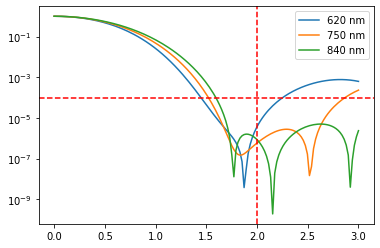

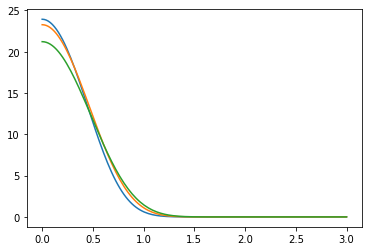

In [499]:
plt.figure()
plt.semilogy(tilts, (np.array(smf_coupling)*np.array(tr))/(max(smf_coupling)*max(tr)),label="620 nm")
plt.semilogy(tilts, (np.array(smf_coupling2)*np.array(tr2))/(max(smf_coupling2)*max(tr2)),label = "750 nm")
plt.semilogy(tilts, (np.array(smf_coupling1)*np.array(tr1))/(max(smf_coupling1)*max(tr1)),label = "840 nm")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.axvline(2,color = "r", linestyle ="--")
plt.legend()

plt.figure()
plt.plot(tilts, np.array(smf_coupling)*np.array(tr)*mask_tr*100)
plt.plot(tilts, np.array(smf_coupling2)*np.array(tr2)*mask_tr*100)
plt.plot(tilts, np.array(smf_coupling1)*np.array(tr1)*mask_tr*100)

print(f"Mask transmission : {mask_tr*100} %")

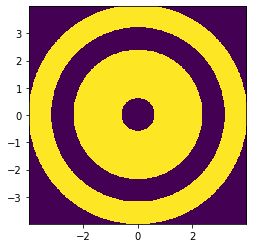

In [501]:
lll = np.linspace(.620, .840, 100)

plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []
smf_coupling3 = []

tr = []
tr1 = []
tr3 = []

for l in tqdm(lll):
    telescope_pupil = make_ring_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),pupil_grid)
    telescope_pupil3 = make_ring_phase_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),0 ,pupil_grid)

    #binary mask
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling.append(wf_smf.total_power)
    
    #no mask
    wf = Wavefront(telescope_pupil3*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr3.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling3.append(wf_smf.total_power)
    
    #transmission on axis
    wf = Wavefront(telescope_pupil,l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr1.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling1.append(wf_smf.total_power)


Text(0, 0.5, 'transmission in %')

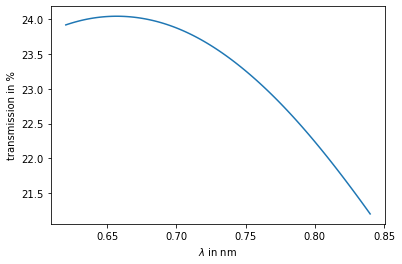

In [504]:
plt.figure()
plt.semilogy(lll, (np.array(smf_coupling)*np.array(tr))/(np.array(smf_coupling1)*np.array(tr1)),label="amplitude mask")
plt.semilogy(lll, (np.array(smf_coupling3)*np.array(tr3))/(np.array(smf_coupling1)*np.array(tr1)),label="no mask")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.legend()
plt.grid()
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Contrast")


plt.figure()
plt.plot(lll, np.array(smf_coupling1)*np.array(tr1)*mask_tr*100)
plt.xlabel("$\lambda$ in nm")
plt.ylabel("transmission in %")

## optimization with flux in the cost function

In [517]:
def cost(x,l1 = .640, l2 =.750,l3=0.82):
    telescope_pupil = make_ring_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),pupil_grid)
    
    wf = Wavefront(telescope_pupil,wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tmax=(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    cmax =wf_smf.total_power

    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/l1 * np.pi * pupil_grid.x / D_pupil),l1 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t2=(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    c2 = wf_smf.total_power
    
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/l2 * np.pi * pupil_grid.x / D_pupil),l2 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t3=(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    c3 = wf_smf.total_power
    
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 * 2 * 0.75/l3 * np.pi * pupil_grid.x / D_pupil),l3 * um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    t4=(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    c4 = wf_smf.total_power
    #print(c2,t2,c3,t3,c4,t4,cmax,tmax)
    #print((c2*t2)/(cmax*tmax),(c3*t3)/(cmax*tmax),(c4*t4)/(cmax*tmax))
    mask_tr = sum(telescope_pupil.real)/sum(full_pupil.real)
    
    return float( (c2*t2)/(cmax*tmax)+(c3*t3)/(cmax*tmax)+(c4*t4)/(cmax*tmax)+8e-4*(1-cmax*tmax*mask_tr))

In [513]:
cost([0.59195437, 0.11726001])

0.0019831476853073896

In [518]:
x=fmin(cost,x0=[0.59195437, 0.11726001])
x

Optimization terminated successfully.
         Current function value: 0.000569
         Iterations: 26
         Function evaluations: 54


array([0.6175734 , 0.13418504])

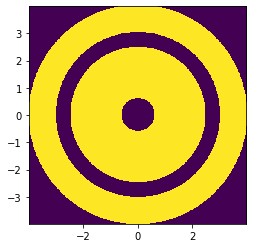

In [519]:
tilts = np.linspace(0, 3, 100)

telescope_pupil = make_ring_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),pupil_grid)
plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []

tr=[]
tr1=[]
tr2=[]

for tilt in tqdm(tilts):
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 * .75/.62 * np.pi * pupil_grid.x / D_pupil),wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 * np.pi * pupil_grid.x / D_pupil),0.750*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr2.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling2.append(wf_smf.total_power)
    
    wf = Wavefront(telescope_pupil*np.exp(1j * tilt * 2 *.75/.84 * np.pi * pupil_grid.x / D_pupil),0.840*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr1.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling1.append(wf_smf.total_power)

mask_tr = sum(telescope_pupil.real)/sum(full_pupil.real)

Mask transmission : 81.2107480721838 %


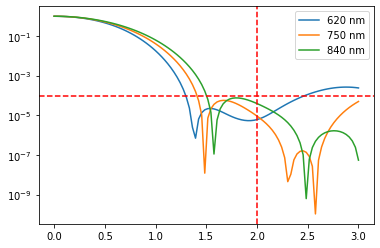

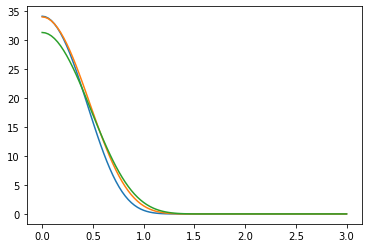

In [520]:
plt.figure()
plt.semilogy(tilts, (np.array(smf_coupling)*np.array(tr))/(max(smf_coupling)*max(tr)),label="620 nm")
plt.semilogy(tilts, (np.array(smf_coupling2)*np.array(tr2))/(max(smf_coupling2)*max(tr2)),label = "750 nm")
plt.semilogy(tilts, (np.array(smf_coupling1)*np.array(tr1))/(max(smf_coupling1)*max(tr1)),label = "840 nm")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.axvline(2,color = "r", linestyle ="--")
plt.legend()

plt.figure()
plt.plot(tilts, np.array(smf_coupling)*np.array(tr)*mask_tr*100)
plt.plot(tilts, np.array(smf_coupling2)*np.array(tr2)*mask_tr*100)
plt.plot(tilts, np.array(smf_coupling1)*np.array(tr1)*mask_tr*100)

print(f"Mask transmission : {mask_tr*100} %")

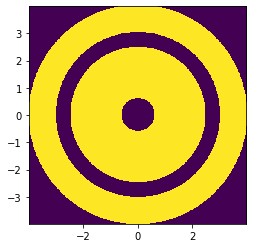

In [521]:
lll = np.linspace(.620, .840, 100)

plt.figure()
imshow_field(telescope_pupil)
ld = wavelength / D_pupil

smf_coupling = []
smf_coupling1 = []
smf_coupling2 = []
smf_coupling3 = []

tr = []
tr1 = []
tr3 = []

for l in tqdm(lll):
    telescope_pupil = make_ring_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),pupil_grid)
    telescope_pupil3 = make_ring_phase_mask(0.15,abs(x[0]),abs(x[0])+abs(x[1]),0 ,pupil_grid)

    #binary mask
    wf = Wavefront(telescope_pupil*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling.append(wf_smf.total_power)
    
    #no mask
    wf = Wavefront(telescope_pupil3*np.exp(1j * 2 *.75/l * 2 * np.pi * pupil_grid.x / D_pupil),l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr3.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling3.append(wf_smf.total_power)
    
    #transmission on axis
    wf = Wavefront(telescope_pupil,l*um)
    wf.total_power = 1
    wf_foc = propagator(wf)
    wf_foc2 = propagator2(apo(wf_foc))
    tr1.append(sum(apo(wf_foc).intensity)/sum(wf_foc.intensity))
    wf_smf = single_mode_fiber.forward(wf_foc2)
    smf_coupling1.append(wf_smf.total_power)


Text(0, 0.5, 'transmission in %')

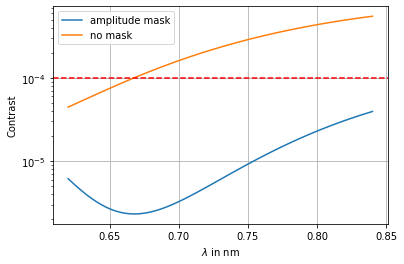

In [522]:
plt.figure()
plt.semilogy(lll, (np.array(smf_coupling)*np.array(tr))/(np.array(smf_coupling1)*np.array(tr1)),label="amplitude mask")
plt.semilogy(lll, (np.array(smf_coupling3)*np.array(tr3))/(np.array(smf_coupling1)*np.array(tr1)),label="no mask")
plt.axhline(1e-4,color = "r", linestyle ="--")
plt.legend()
plt.grid()
plt.xlabel("$\lambda$ in nm")
plt.ylabel("Contrast")


plt.figure()
plt.plot(lll, np.array(smf_coupling1)*np.array(tr1)*mask_tr*100)
plt.xlabel("$\lambda$ in nm")
plt.ylabel("transmission in %")